# The epidemiology of antibiotic resistance in hospitals: Paradoxes and prescriptions
Marc Lipsitch, Carl Bergstrom and Bruce Levin

In [2]:
import pandas as pd
import numpy as np
import os

from scipy.interpolate import UnivariateSpline


In [36]:

def binomial_transition(var, rate, dt=1):
    kb = np.maximum(1.0 - np.exp(-rate * dt), 0)
    num_ind   = np.random.binomial(list(var), kb )

    return num_ind

def deterministic_transition(var, rate, dt=1):

    return var * rate * dt

def model(x,  beta, tau1, tau2, c, num_ensembles=300, dt=1, transition=binomial_transition):
    """[summary]

    Args:
        x ([type]):     State variables                            | Dim: [num_variables, num_age_groups, num_ensembles]
        beta ([type]):  Population level contact rate              | Dim: [num_ensembles]
        ifr ([type]):   Age group dependent infect fatality rates. | Dim: [num_age_groups, num_ensembles]
        alpha ([type]): Age group dependent ascertainment rates.   | Dim: [num_age_groups, num_ensembles]
        N ([type]):     Population in each age group.              | Dim: [num_age_groups]

    Returns:
        [type]: [description]
    """

    m       = 30/100  # Proportion of admitted already colonized individuals with the sensitive strain [adim]
    mu      = 1/15    # Average duration of hospital stay [days]
    gamma   = 1/45    # Average time from admission or colonization until spontaneous clearance of bacteria carriage [days]
    c       = c       # Fitness cost of resistance to drug 1
    tau1    = tau1    # Rate of treatment with drug 1
    tau2    = tau2    # Rate of treatment with drug 2

    X       = x[0, :] # Non colonized individuals
    S       = x[1, :] # Colonized individuals with the sensitive strain
    R       = x[2, :] # Colonized individuals with the resistant strain

    # force of infection of sensitive strain
    foi_s = beta * S

    # force of infection of resistant strain
    foi_r = beta * (1-c) * R


    # Transitions
    adm_s         = transition(m, mu, dt)
    adm_x         = transition((1-m), mu, dt)

    x2s           =  transition(X, foi_s, dt) # non-colonized to colonized with sensitive strain
    x2r           =  transition(X, foi_r, dt) # non-colonized to colonized with resistant strain
    s2x_tau1      =  transition(S, tau1, dt)
    s2x_tau2      =  transition(S, tau2, dt)
    r2x_tau1      =  transition(R, tau2, dt)

    s2x_clearance =  transition(S, gamma, dt)
    r2x_clearance =  transition(R, gamma, dt)
    s2exit        =  transition(S, mu, dt)
    r2exit        =  transition(R, mu, dt)
    x2exit        =  transition(X, mu, dt)

    # Updates
    X  = X + adm_x - x2s - x2r    + s2x_tau1 + s2x_tau2 + r2x_tau1 + s2x_clearance + r2x_clearance - x2exit
    S  = S + adm_s + x2s - s2exit - s2x_tau1 + s2x_tau2 - s2x_clearance
    R  = R + x2r         - r2exit - r2x_tau1 - r2x_clearance

    return np.minimum(np.maximum(np.array([X, S, R]), 0), 1)

In [37]:
x0 =  [[0.9, 0.05, 0.05]]


num_ensembles = 1
num_days      = 60
num_vars      = 3

x_all = np.full((num_vars, num_days+1, num_ensembles), np.nan)
x_all[:,0,:] = np.expand_dims(x0, -1)

beta = 1
tau1 = 1/5
tau2 = 0
c    = 0

for t_idx in range(num_days):

    x_all[:,t_idx+1,:] = model(x_all[:,t_idx,:],  beta, tau1, tau2, c, num_ensembles=300, dt=1, transition=deterministic_transition)

x_all.shape

(3, 61, 1)

(Text(0.5, 0, 'Days'), Text(0, 0.5, 'Frequency'))

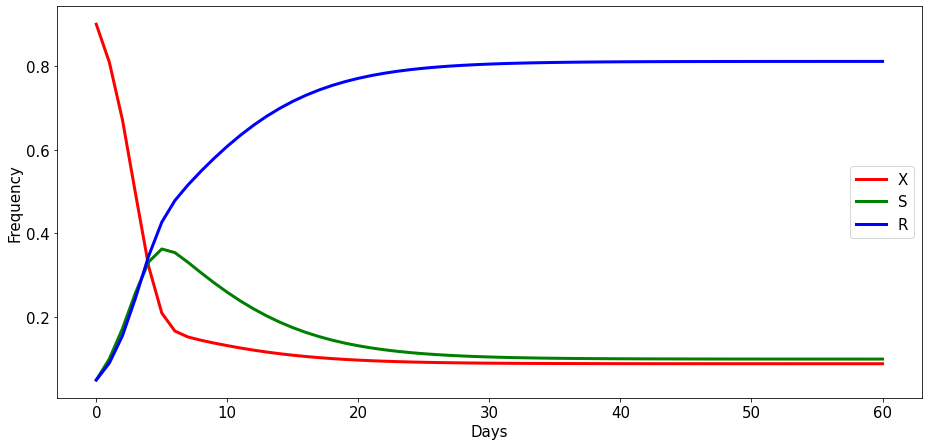

In [38]:
import matplotlib.pyplot as plt
plt.rc('font', size=15) #controls default text size


fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))

ax.plot(range(num_days+1), x_all[0, : ], color="r", lw=3, label="X")
ax.plot(range(num_days+1), x_all[1, : ], color="g", lw=3, label="S")
ax.plot(range(num_days+1), x_all[2, : ], color="b", lw=3, label="R")

ax.legend()
ax.set_xlabel("Days"), ax.set_ylabel("Frequency")


In [69]:


num_ensembles = 300
num_days      = 60
num_vars      = 3

x0 =  [[0.9, 0.05, 0.05]]
x0 =  np.expand_dims(x0, -1) * np.ones((1, num_ensembles))

x_all = np.full((num_vars, num_days+1, num_ensembles), np.nan)
x_all[:,0,:] = x0

betas =  np.linspace(1, 3, num_ensembles)
tau1  =  1 /  np.linspace(1, 15, num_ensembles)
tau2  =  1 / np.linspace(1, 15, num_ensembles)
c     = 0

for t_idx in range(num_days):

    x_all[:,t_idx+1,:] = model(x_all[:,t_idx,:],  beta, tau1, tau2, c, num_ensembles=300, dt=1, transition=deterministic_transition)



(Text(0.5, 0, 'Days'), Text(0, 0.5, 'Frequency'))

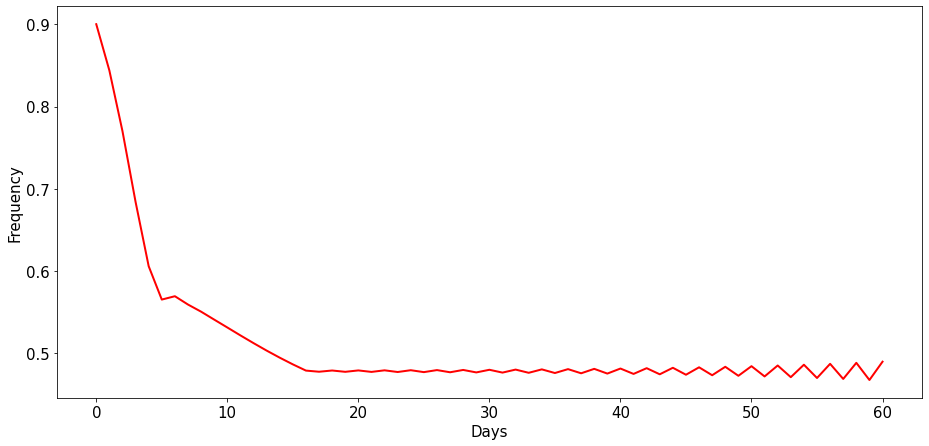

In [74]:
import matplotlib.pyplot as plt
plt.rc('font', size=15) #controls default text size


fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2))

ax.plot(range(num_days+1), x_all[0, :, 50], color="r", lw=2, label="X")

#ax.legend()
ax.set_xlabel("Days"), ax.set_ylabel("Frequency")


In [56]:
x_all[0, :, 150]

array([0.9, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])